<a href="https://colab.research.google.com/github/evillag/uncertainty_gan/blob/main/CERN_UE_Likelihood_Estimation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import matplotlib.pyplot as plt
import numpy as np

from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KernelDensity

Importing sample data for training and testing. Refer to `[Feature_Densities]_CERN_uncertainties.ipynb` for implementation.

In [2]:
dir = 'drive/MyDrive/Colab Notebooks/embeddings/layer4_pre_activation/'
pion_predictions = np.load(dir + 'pion_predictions.npy')
print('Embedding shape:', pion_predictions.shape)

Embedding shape: (948325, 128)


Kernel Density Estimation (KDE) with grid search cross-validation to compute the optimal bandwidth if h=None.

Returns the tuple (estimation, bandwidth)

In [3]:
def kde(data, target_space, h=None, debug=False):
  data = data.reshape(-1, 1)
  target_space = target_space.reshape(-1, 1)

  if not h:
    bandwidths = np.linspace(.1, 1, 25)
    grid_search = GridSearchCV(KernelDensity(), {'bandwidth': bandwidths}).fit(data)
    h = grid_search.best_estimator_.bandwidth

    if debug:
      print(f'Computed h = {h} with score {grid_search.best_score_}')

  kde = KernelDensity(bandwidth=h).fit(data)
  return np.exp(kde.score_samples(target_space)), h

# Likelihood algorithms

## Histogram intersection

Computed as the intersecting area between 2 histograms, divided by all non-interecting areas to guarantee results in range [0, 1]. Intersection is computed as:

$\sum_{i=1}^{N}min(p_i,q_i)$

Where $p,q$ are the input histograms and $N$ the number of bins in $p$ and $q$.

## Jensen-Shannon distance

Computed as the square root of the mean Kullback-Leibler divergence between 2 distributions $p,q$ and their "mean distribution", formally defined as:

$m=\frac{p+q}{2}$

$JSD(p,q)=\sqrt{\frac{KLD(p,m)+KLD(q,m)}{2}}$

$KLD(p,q)=\sum_{i=1}^{N}p_ilog_2\left(\frac{p_i}{q_i}\right)$ (bound by $p_i,q_i\neq0$)

$p$ and $q$ are divided by their totals to guarantee results in range [0, 1]. The final likelihood estimation would then be $1-JSD(p,q)$ so that the final value is directly proportional to the estimated likelihood.

In [4]:
def histogram_intersection(hist1, hist2):
  intersection = np.minimum(hist1, hist2).sum()
  total = np.sum((hist1, hist2))
  return intersection / (total - intersection)

def kullback_leibler_divergence(dist1, dist2):
  indices = (dist1 != 0) & (dist2 != 0)
  dist1, dist2 = dist1[indices], dist2[indices]
  return (dist1 * np.log2(dist1 / dist2)).sum()

def jensen_shannon_distance(dist1, dist2):
  kld = kullback_leibler_divergence
  dist1 = dist1 / dist1.sum()
  dist2 = dist2 / dist2.sum()
  mean_dist = (dist1 + dist2) / 2
  return np.sqrt((kld(dist1, mean_dist) + kld(dist2, mean_dist)) / 2)

# Sanity checks

1. Two identical distributions $\mathcal{N}(0,1)$.
2. Two offset distributions $\mathcal{N}(-1,1)$ and $\mathcal{N}(1,1)$.
3. Two near-independent distributions $\mathcal{N}(-2,1)$ and $\mathcal{N}(2,1)$.

Histogram intersections and inverse Jensen-Shannon distances are computed for each check, expecting smaller likelihood estimates as the distributions grow further apart.

Check 1:
Hist intersection: 86.74%
Inverse JS distance: 92.03%

Check 2:
Hist intersection: 18.98%
Inverse JS distance: 29.7%

Check 3:
Hist intersection: 1.99%
Inverse JS distance: 3.7%


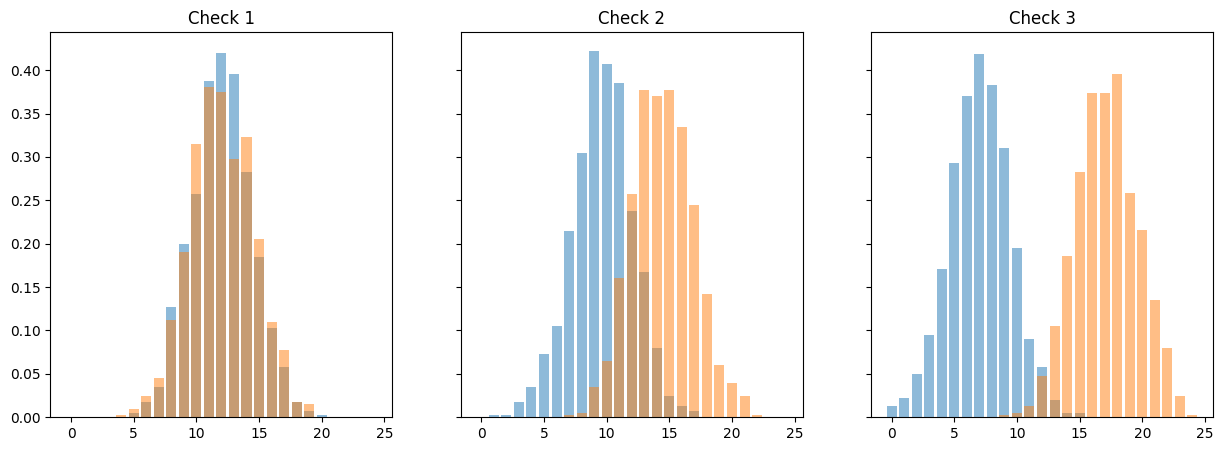

In [5]:
bins = 25
x = range(bins)
hist_range = -5, 5

def plot_histograms(ax, i, title, mean1, std1, mean2, std2):
  p = np.random.normal(mean1, std1, 1000)
  q = np.random.normal(mean2, std2, 1000)

  p = np.histogram(p, bins, hist_range, True)[0]
  q = np.histogram(q, bins, hist_range, True)[0]

  ax[i].set_title(title)
  ax[i].bar(x, p, alpha=.5)
  ax[i].bar(x, q, alpha=.5)

  intersection = histogram_intersection(p, q)
  inv_js_distance = 1 - jensen_shannon_distance(p, q)

  print(f'Hist intersection: {round(intersection * 100, 2)}%')
  print(f'Inverse JS distance: {round(inv_js_distance * 100, 2)}%')

fig, ax = plt.subplots(1, 3, sharex=True, sharey=True, figsize=(15, 5))

print('Check 1:')
plot_histograms(ax, 0, 'Check 1', 0, 1, 0, 1)

print('\nCheck 2:')
plot_histograms(ax, 1, 'Check 2', -1, 1, 1, 1)

print('\nCheck 3:')
plot_histograms(ax, 2, 'Check 3', -2, 1, 2, 1)

plt.show()

# Results

In [6]:
def plot_hist_kde_mini(ax, i, j, x, hist, kde):
  ax[i, j].tick_params(left=False, labelleft=False, bottom=False, labelbottom=False)
  ax[i, j].bar(x, hist, 1)
  ax[i, j].plot(x, kde, color='tab:orange')

def estimate_likelihoods(dataset, sample_size, n_bins, n_samples=None, n_features=None, bandwidth=None, plot=False):
  if not n_samples:
    n_samples = dataset.shape[0] // sample_size

  if not n_features:
    n_features = dataset.shape[1]

  hist_range = dataset.min(), dataset.max()
  target_space = np.linspace(hist_range[0], hist_range[1], n_bins)
  x = range(n_bins)

  hist_intersections = np.zeros((n_samples, n_features))
  js_distances = np.zeros((n_samples, n_features))

  if plot:
    fig, ax = plt.subplots(n_samples, n_features, sharex=True, sharey=True, figsize=(n_features, n_samples))

  for j in range(n_features):
    train_sample = dataset[:sample_size, j]
    train_sample_kde = kde(train_sample, target_space, bandwidth)[0]

    for i in range(n_samples):
      test_sample = dataset[sample_size * i:sample_size * (i + 1), j]
      test_sample_hist = np.histogram(test_sample, n_bins, hist_range, True)[0]

      hist_intersections[i, j] = histogram_intersection(test_sample_hist, train_sample_kde)
      js_distances[i, j] = jensen_shannon_distance(test_sample_hist, train_sample_kde)

      if plot:
        plot_hist_kde_mini(ax, i, j, x, test_sample_hist, train_sample_kde)

  if plot:
    plt.show()

  return hist_intersections, 1 - js_distances

hist_intersections, inv_js_distances = estimate_likelihoods(pion_predictions, 10000, 100, bandwidth=.15)

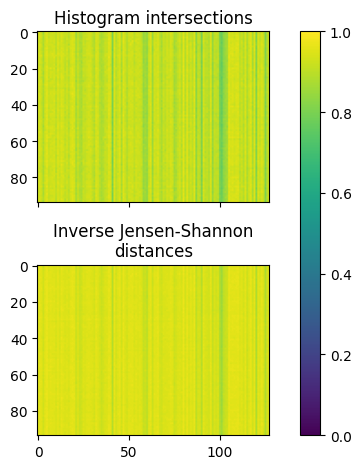

In [7]:
def plot_likelihoods(hist_intersections, inv_js_distances):
  fig, ax = plt.subplots(2, 1, sharex=True)

  ax[0].set_title('Histogram intersections')
  im = ax[0].imshow(hist_intersections, vmin=0, vmax=1)

  ax[1].set_title('Inverse Jensen-Shannon\ndistances')
  ax[1].imshow(inv_js_distances, vmin=0, vmax=1)

  plt.tight_layout()
  plt.colorbar(im, ax=ax)
  plt.show()

plot_likelihoods(hist_intersections, inv_js_distances)

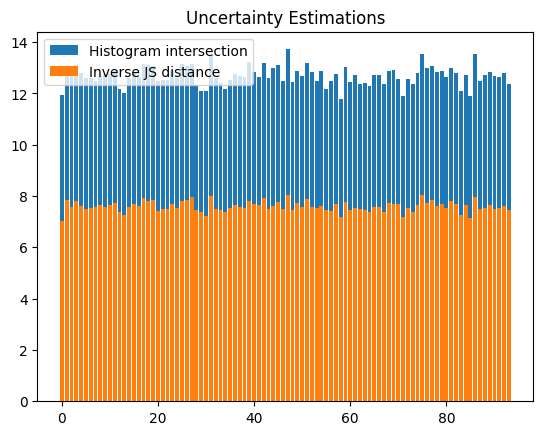

In [8]:
def ue(likelihoods):
  return -np.log(likelihoods).sum(1)

def plot_ue(hist_intersections, inv_js_distances):
  ue_intersections = ue(hist_intersections)
  ue_inv_js_distances = ue(inv_js_distances)

  x = range(hist_intersections.shape[0])

  plt.title('Uncertainty Estimations')
  plt.bar(x, ue_intersections, label='Histogram intersection')
  plt.bar(x, ue_inv_js_distances, label='Inverse JS distance')
  plt.legend()
  plt.show()

plot_ue(hist_intersections, inv_js_distances)